In [16]:
import pandas as pd
from os import path

#load

loansData=pd.read_csv('https://raw.githubusercontent.com/LakheyM/firstdata/a916909b8cae1b10601dbb642e5e746c83b4d211/loansData_clean.csv')
#loansData=pd.read_csv('C:\\Users\\Mnsh\\Projects\\loansData_clean.csv')

print (loansData.head())

   Amount.Requested  Amount.Funded.By.Investors  Interest.Rate Loan.Length  \
0           20000.0                     20000.0           0.09   36 months   
1           19200.0                     19200.0           0.12   36 months   
2           35000.0                     35000.0           0.22   60 months   
3           10000.0                      9975.0           0.10   36 months   
4           12000.0                     12000.0           0.12   36 months   

         Loan.Purpose Debt.To.Income.Ratio State Home.Ownership  \
0  debt_consolidation               14.90%    SC       MORTGAGE   
1  debt_consolidation               28.36%    TX       MORTGAGE   
2  debt_consolidation               23.81%    CA       MORTGAGE   
3  debt_consolidation               14.30%    KS       MORTGAGE   
4         credit_card               18.78%    NJ           RENT   

   Monthly.Income  FICO.Range  Open.CREDIT.Lines  Revolving.CREDIT.Balance  \
0         6541.67       735.0               14.0  

In [17]:
import statsmodels.api as sm


#create a new column reshaping the data as required
loansData['IR_TF']=loansData['Interest.Rate'].map(lambda x: 0 if x < .12 else 1)
loansData.ix[:,['IR_TF', 'Interest.Rate']].head()  #coeffs came with signs reversed so had to look back and correct
loansData['IR_TF'] = loansData['IR_TF'].map(lambda x: 0 if x > 0 else 1)#coeffs came with signs reversed so due to IR_TF
loansData.ix[:,['IR_TF', 'Interest.Rate']].head()



,IR_TF,Interest.Rate
0,1,0.09
1,0,0.12
2,0,0.22
3,1,0.10
4,0,0.12


In [18]:
loansData['const']=loansData['Interest.Rate'].map(lambda x: 1)
loansData.const.head()

0    1
1    1
2    1
3    1
4    1
Name: const, dtype: int64

In [19]:
#list of indep vars
ind_vars = ['const', 'FICO.Range','Amount.Requested' ]
loansData[ind_vars].head()

,const,FICO.Range,Amount.Requested
0,1,735.0,20000.0
1,1,715.0,19200.0
2,1,690.0,35000.0
3,1,695.0,10000.0
4,1,695.0,12000.0


In [20]:
#fitting logit model
logit = sm.Logit(loansData['IR_TF'], loansData[ind_vars])  #OR sm.Logit(y, X)  - where y = dep var and x is indep var

In [21]:
result = logit.fit()
coeff = result.params
print(coeff)
print("Coeff at index 0 is: ", coeff[0])

Optimization terminated successfully.
         Current function value: 0.316107
         Iterations 8
const              -57.497954
FICO.Range           0.083199
Amount.Requested    -0.000172
dtype: float64
Coeff at index 0 is:  -57.4979541415


In [22]:
#interest_rate = −57.49 + 0.0831(FicoScore) − 0.000172(LoanAmount)
interest_rate = 57.49 

In [23]:
#Now dependant var Int_rate can be expressed in terms of log function with above coeff
#Need to bring it back to linear for to get probability
#Finally interpret the according the set threshold level whether someone gets loan or not


In [24]:
#define a function to dep var y(interate_rate), so that any value can be passed on as arguments to get specific P
# interest_rate = −60.125 + 0.087423(FicoScore) − 0.000174(LoanAmount)
# p(x) = 1/(1 + e^(intercept + 0.087423(FicoScore) − 0.000174(LoanAmount))
#p(x) = 1/(1 + e^(x))   whre x = interest_rate
#linear part of predictor

def ir_calc(FicoScore, LoanAmount):
    x=coeff[0] + coeff[1]*FicoScore + coeff[2]*LoanAmount
    return x
print (ir_calc(720, 10000))

0.682613505095


In [25]:
#calculate probability given the interest rate
# p(x) = 1/(1 + e^(intercept + 0.087423(FicoScore) − 0.000174(LoanAmount))

import math
def logistic_function(x):
    return 1/(1+math.exp(x))

print(logistic_function(.682))
    

0.3358150695976666


In [26]:
#Someone is not eligible for loan of 10000 if he/she has FICO score of 720 keeping theshold for loan sacntion at 0.7

In [27]:
#plotting the graph
#keep Loan amount fixed at $ 100000
#range for FICO score is 500 ot 1000
#Plot for probaility (logit fxn) against linear form of int_rest
#FICO range is taken fron 550 to 950 ie 400 items are iterated
#Make a list of px distribution and plot againt equal no of items corresponding to FICO range

def ir_prob_finder(x):
    lin_ir_list =[]
    x=500
    for i in range (400):
        lin_ir_list.append(logistic_function(ir_calc(x, 10000))) #probably appended in reverse order
        #lin_ir_list.append(ir_calc(x, 10000))  creates a list of int_rest values to be passed on to logistic_fxn
        x +=1
    #print(lin_ir_list)
    return lin_ir_list
prob_list=[]
prob_list=ir_prob_finder(500) #reversing the order of list
prob_list=prob_list[::-1]
#print(prob_list)



In [28]:
#prob_list_q = prob_list[::-1] # simple reversal does not work, reversing needs to be done at coeff level 
#can add the threshold here to indicate 1 above p = .7 and 0 if not  --creating a list then plot below

loan_YN=[]
for i in range (len(prob_list)):
    
    if prob_list[i] > 0.7:
        loan_YN.append(1)
    else:
        loan_YN.append(0)
print (loan_YN)
  


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [29]:
#creating a prob list that gives 1-q
def ir_prob_finder_q(x):
    lin_ir_list_q =[]
    x=500
    for i in range (400):
        lin_ir_list_q.append(logistic_function(ir_calc(x, 10000)*-1)) #probably appended in reverse order
        #ir_calc *-1 reverses the sign of coeff and calculates the values for 1-p or q
        #lin_ir_list_q.append(ir_calc(x, 10000))  creates a list of int_rest values to be passed on to logistic_fxn
        x +=1
    #print(lin_ir_list)
    return lin_ir_list_q
prob_list_q=[]
prob_list_q=ir_prob_finder_q(500) #reversing the order of list
prob_list_q=prob_list_q[::-1]
#print(prob_list_q)

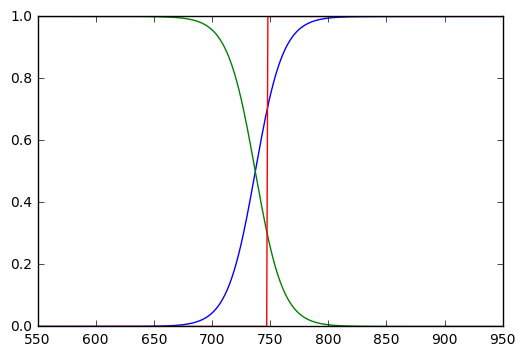

In [30]:
#printing a graph
#fig = plt.figure()
#plt.plot_date(x=Date_list, y=Value_list)
#plt.show()
fico=[]
fico =(loansData['FICO.Range'].dropna())
import matplotlib.pyplot as plt
fig = plt.figure
plt.plot(range(550, 950), prob_list)
plt.plot(range(550, 950), prob_list_q) # simple reversal  doesnot work, reversing needs to be done at coeff level
#plt.plot(loan_YN, prob_list)
plt.plot(range(550, 950), loan_YN)
plt.show()


